# MDP Basics with Inventory Control
> An industrial example of using Markov decision processes for inventory control.

This is a great example of using an MDP to define a problem. I intentionally keep it simple to make all the main parts of the MPD clear.

Imagine you own a really simple shop. It sells one product and you have limited room for stock. The question is, when should you restock?

## Setup

In [ ]:
# !pip install -q banditsbook==0.1.1
!pip install -q pandas==1.1.2
!pip install -q matplotlib==3.3.2

In [ ]:
%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd
from enum import Enum

## Scenario

Defining a problem in RL terms is a common issue for people who have a background in data science. Gaining more experience in the problem definition phase is worthwhile before you move on to other ways of solving MDPs.

Inventory control is a good example to start with because it is both useful and easy to understand. This example has direct analogies with pricing, optimal stopping (selling an asset), maintenance, and more. I start with a very simple example and then expand it to a more complex version.

Imagine you own a small shop. This shop is so small you only have a single product. Each day customers buy your product so you need to restock. If you run out of stock, then you can’t sell your product and make any money; you don’t want to run out of stock. You rent your shop and it costs you a certain amount of money per square meter. You don’t want to stock millions of items because you would need a larger premises. I could define many high-level problems, like the optimal size for the premises, or minimizing the delivery charges, but to start simply, I define the problem as deciding the best point to restock.

Let s represent the number of items in stock on a particular day. This is the state of the environment. In an attempt to keep things as simple as possible, I assume three possible states: no stock, one item in stock, or two items in stock, $\mathcal{I}=\{0,1,2\}$.

![](https://github.com/recohut/nbs/blob/main/raw/_images/T159137_1.png?raw=1)

## Actions and Potential Strategies

Given the current state, the agent can perform an action. Keeping it simple, assume that the agent can take one of two actions. Either restock, which orders 1 new product, or do nothing: $\mathcal{A}=\{restock,none\}$. If the current state was 1 and the agent performs the action, the next state will be 2. Also assume that you cannot order any stock when you are at full capacity.

In [ ]:
class Action(Enum):
    NONE = 0
    RESTOCK = 1

    @staticmethod
    def keep_buying_action(current_state) -> Enum:
        if current_state == 2:
            return Action.NONE
        else:
            return Action.RESTOCK

    @staticmethod
    def random_action(current_state) -> Enum:
        if current_state == 2:
            return Action.NONE
        if np.random.randint(len(Action)) == 0:
            return Action.NONE
        else:
            return Action.RESTOCK

    @staticmethod
    def zero_action(current_state) -> Enum:
        if current_state == 0:
            return Action.RESTOCK
        else:
            return Action.NONE

print("There are {} actions.".format(len(Action)))

There are 2 actions.


## Transition matrix

What are the probabilities that the agent shifts from one state to another? Since you are simulating the environment, you have to choose those, but they could come from observations of your shop. Say that the probability of a single sale during a day, $p(sale)$, is 0.7. In the future you could predict the number of items sold. But for now, I use a Bernoulli distribution again. This means that in each state there is a 70% probability of a sale and a 30% probability of no sale. I’m going to develop an environment to simulate the shop. In this instance I’m going to declare all the transition probabilities myself.



In [ ]:
p_sale = 0.7 # Probability of a sale in one step
n_steps = 100 # Number of steps to run experiment for
np.random.seed(42)

Now, since MDP is a model-based environment, that means we have the complete knowledge of our environment. To represent the environment, we use transition probabilities. There are 3 ways to do this:

1. Using a table with all combinations of $\{s,a,s',p(s'|s,a),r\}$ tuple.
2. Transition graph.
3. The final way to represent the transition probabilities is with a matrix for each action, known as the transition matrix.

You already placed a constraint that you cannot restock if the stockroom is full. That is one hard rule. But after that, what is the best action to take? If you look purely at the rewards, which represent the goal, then there is only a positive reward on making sales. Crucially, there is no negative reward for placing orders. In other words, according to the reward matrix, it doesn’t cost anything to keep stock and it is free to order new stock. Given this reward structure, the best strategy is to keep ordering as much as you can.

Even though the strategy is obvious in this case, you should always test your idea—the scientific method. It is always a good idea to compare your theory against other baselines.

In [ ]:
# The Transition Matrix represents the following states:
# State 0
# State 1
# State 2
transition_matrix = [
    # No action
    [
        [1, 0, 0],
        [p_sale, 1 - p_sale, 0],
        [0, p_sale, 1 - p_sale],
    ],
    # Restock
    [
        [p_sale, 1 - p_sale, 0],
        [0, p_sale, 1 - p_sale],
    ],
]

## Reward matrix

The final thing you need is a reward, $r$. Your shop needs to make money, so you can reward yourself every time you sell a product. But sales are possible only if the product is in stock at the time, or if you restocked just in time. This means the reward is conditional on the current state and on a sale; no sale means no reward.

$$r = \begin{cases} 1\ if\ s>0\ and\ a\ sale \\ 1\ if\ a=restock\ and\ a\ sale \\ 0\ otherwise\end{cases}$$

In [ ]:
reward_matrix = [
    # No action
    [
        [0, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
    ],
    # Restock
    [
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 0],
    ],
]

## Testing Different Restocking Strategies

To demonstrate how this all fits together, let’s imagine a single iteration of the environment. You start with an initial state, feed that to the “agent” to decide an action, then the environment uses the transition matrix to mutate the state and finally it receives a reward.

Let’s create a helper function to do all of that.

In [ ]:
def environment(current_state: int, action: int) -> (int, int):
    # Get the transition probabilities to each new state
    current_transition_probabilities = \
        transition_matrix[action.value][current_state]
    
    # Use the transition probabilitis to transition to a new state
    next_state = np.random.choice(
        a=[0, 1, 2],
        p=current_transition_probabilities
    )
    
    # Get the reward for the new state (was there a sale?)
    reward = reward_matrix[action.value][current_state][next_state]
    return (next_state, reward)

current_state = 1 # Current state, one product in stock
action = Action.RESTOCK # Current action, as chosen by a strategy
for i in range(10): # What happens if we run this multiple times?
    next_state, reward = environment(current_state, action) # Environment interface
    print(f"trial {i}: s={current_state}, a={action}, s'={next_state}, r={reward}")

trial 0: s=1, a=Action.RESTOCK, s'=1, r=1
trial 1: s=1, a=Action.RESTOCK, s'=2, r=0
trial 2: s=1, a=Action.RESTOCK, s'=2, r=0
trial 3: s=1, a=Action.RESTOCK, s'=1, r=1
trial 4: s=1, a=Action.RESTOCK, s'=1, r=1
trial 5: s=1, a=Action.RESTOCK, s'=1, r=1
trial 6: s=1, a=Action.RESTOCK, s'=1, r=1
trial 7: s=1, a=Action.RESTOCK, s'=2, r=0
trial 8: s=1, a=Action.RESTOCK, s'=1, r=1
trial 9: s=1, a=Action.RESTOCK, s'=2, r=0


Recall that the sale is a stochastic variable. Sometimes there is, sometimes there is not. When there is no sale, the stock (state) increases to 2, but there is no reward. When there is a sale, the stock (state) states at 1 because we sold one and restocked by one, and receive a reward of 1.



Now let’s run this over a longer period of time, using different strategies. The three strategies I want to try are: always restock, restock when no stock left (just in time), and random restock.

In [ ]:
# The different strategies
strategies = [("Keep Buying", Action.keep_buying_action),
            ("Upon Zero", Action.zero_action), ("Random", Action.random_action)]
result = [] # Results buffer

for (policy_name, action_getter) in strategies:
    np.random.seed(42) # This is really important, otherwise different strategies will experience sales
    reward_history = [] # Reward buffer
    current_state = 2 # Initial state
    total_reward = 0
    for i in range(n_steps):
        reward_history.append(total_reward)
        action = action_getter(current_state) # Get new action for strategy
        next_state, reward = environment(current_state, action) # Environment interface
        print("Moving from state {} to state {} after action {}. We received the reward {}."
              .format(current_state, next_state, action.name, reward))
        total_reward += reward
        current_state = next_state # Set next state to current state and repeat
    print("The total reward was {}.".format(total_reward))

    # Pandas/plotting stuff
    series = pd.Series(
        reward_history,
        index=range(n_steps),
        name="{} ({})".format(policy_name, total_reward / n_steps))
    result.append(series)
df = pd.concat(result, axis=1)

Moving from state 2 to state 1 after action NONE. We received the reward 1.
Moving from state 1 to state 2 after action RESTOCK. We received the reward 0.
Moving from state 2 to state 2 after action NONE. We received the reward 0.
Moving from state 2 to state 1 after action NONE. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 2 after action RESTOCK. We received the reward 0.
Moving from state 2 to state 1 after action NONE. We received the reward 1.
Moving from state 1 to state 2 after action RESTOCK. We received the reward 0.
Moving from state 2 to state 1 after action NONE. We received the reward 1.
Moving from state 1 to state 2 after action RESTOCK. We received the reward 0.
Moving from state 2 to state 2 after action NONE. We received the r

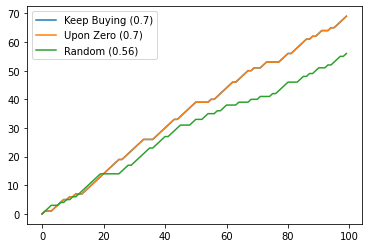

In [ ]:
(df).plot();

The restock and just in time curves are overlapping, so let me add a little jitter so you can see them…

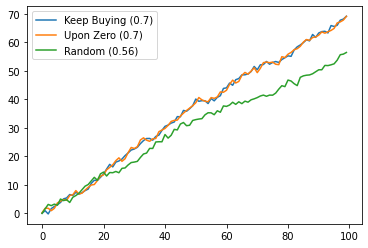

In [ ]:
(df + np.random.normal(size=df.shape)*0.5).plot();

So you can see that the always buy and just in time strategies are equivalent, given this reward function. Because holding stock isn’t penalised. Obviously this picture would change if we made the simulation more complex.

I’d like to demonstrate what happens when you don’t fix the random seeds. Let’s run the exact same code again, but this time skip the random seed setting.



In [ ]:
# The different strategies
strategies = [("Keep Buying", Action.keep_buying_action),
            ("Upon Zero", Action.zero_action), ("Random", Action.random_action)]
result = [] # Results buffer

for (policy_name, action_getter) in strategies:
    # np.random.seed(42) # Commenting this line out!!!
    reward_history = [] # Reward buffer
    current_state = 2 # Initial state
    total_reward = 0
    for i in range(n_steps):
        reward_history.append(total_reward)
        action = action_getter(current_state) # Get new action for strategy
        next_state, reward = environment(current_state, action) # Environment interface
        print("Moving from state {} to state {} after action {}. We received the reward {}."
              .format(current_state, next_state, action.name, reward))
        total_reward += reward
        current_state = next_state # Set next state to current state and repeat
    print("The total reward was {}.".format(total_reward))

    # Pandas/plotting stuff
    series = pd.Series(
        reward_history,
        index=range(n_steps),
        name="{} ({})".format(policy_name, total_reward / n_steps))
    result.append(series)
df = pd.concat(result, axis=1)

Moving from state 2 to state 2 after action NONE. We received the reward 0.
Moving from state 2 to state 2 after action NONE. We received the reward 0.
Moving from state 2 to state 1 after action NONE. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 2 after action RESTOCK. We received the reward 0.
Moving from state 2 to state 2 after action NONE. We received the reward 0.
Moving from state 2 to state 1 after action NONE. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received th

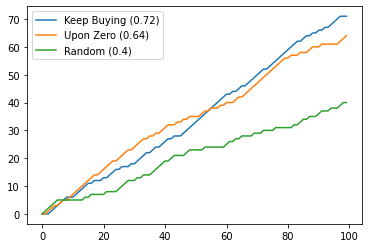

In [ ]:
df.plot();

Now look! The strategies appear different. This is because of fluctuations in the probability of making a sale. Random chance might produce no sales for a long period of time and hamper an otherwise sensible strategy.

This is a particularly challenging topic in RL. Most environments are stochastic and algorithms could be too. In general you need to repeat an experiment many times to average out the random effects.

Changing the environment to include more stock, or allowing people to buy more than one item at a time, affects the best restocking strategy. Altering the reward function by introducing a penalty for ordering—a charge for delivery, for example—also alters the best strategy. In these cases it might be better to wait until you have zero stock then order a full 2 units worth of product. The reward function defines what problem you want solved, not how to achieve it.

Standard MDPs require the state to be fully observable. If the agent cannot observe the true state of the system, then how can it pick an optimal action? There is an extension to the MDP model called partially observable MDPs (POMDPs). Here, you can introduce an extra mapping between the observations and the actual state. In other words, the agent would need to learn how to map actions to observations that are mapped to states that it cannot observe, a double mapping. As you can imagine, this is tricky to solve, because of more unknowns. In many applications, engineers trick the system back into a standard MDP by feeding more information from previous time steps into the current time step. Knowledge of the past can help the agent figure out how the actions altered the perceived states over a longer period of time.

I also want to stress that the important thing here is the observation of the state, not the environment. Agents do not concern themselves about what is happening behind the MDP interface. You can alter the simulation as much as you want, so long as you do not change the interface. In the inventory example, if you altered the customer’s buying behavior, it only affects the optimal policy. It does not change how the agent learns.